<목차>
- Document Loaders
- Custom Document Loaders
  - Standard Document Loader
- Working with Files
  - BaseBlobParser 
  - Blob Loaders
  - Generic Loader

- from langchain_community.document_loaders import TextLoader
- from langchain_core.document_loaders import BaseLoader
- from langchain_core.documents import Document
- from langchain_core.document_loaders import BaseBlobParser, Blob
- from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader
- from langchain_community.document_loaders.generic import GenericLoader

==> BaseBlobParser와 document_loaders.blob_loaders 의 용법을 아직은 이해하지 못했다. 사용해보면서 익힐 필요가 있겠다.

## Document Loaders
- `Document`는 text와 metadata로 이루어져 있습니다.

In [ ]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("./index.md")
loader.load()

## Custom Document Loaders
- 랭체인의 Document 객체는 텍스트와 메타데이터(저자 이름, 작성 날짜 등)을 포함하고 있습니다.
- Document 객체는 프롬프트로 포맷화되어 LLM에 입력으로 들어갑니다.
- Document는 즉시 사용되거나, 인덱스화 되어 Retrieval에 사용됩니다.
- Document Loading을 위한 주요 추상화는 아래와 같습니다.

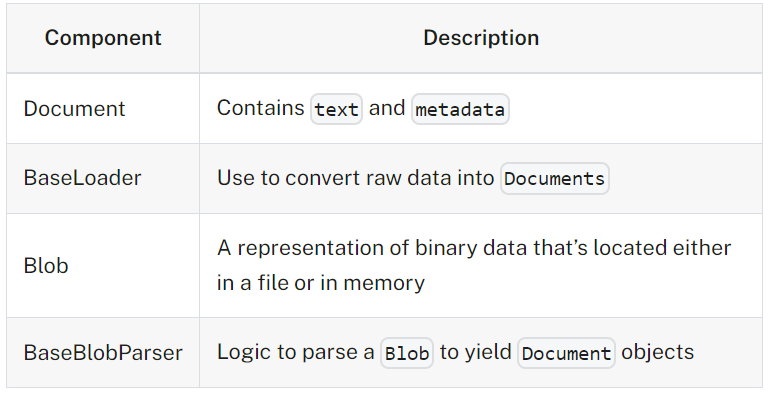

아래는 커스텀 데이터 로더를 생성하는 방법을 포함합니다.
1. BaseLoader를 상속하여 표준 Document Loader를 생성합니다.
2. BaseBlobParser를 사용하여 파서를 만들고 Blob 및 BlobLoaders와 함께 사용합니다. 이는 주로 파일 작업 시 유용합니다.

### Standard Document Loader
- 표준 도큐먼트 로더는 아래의 인터페이스를 제공합니다.

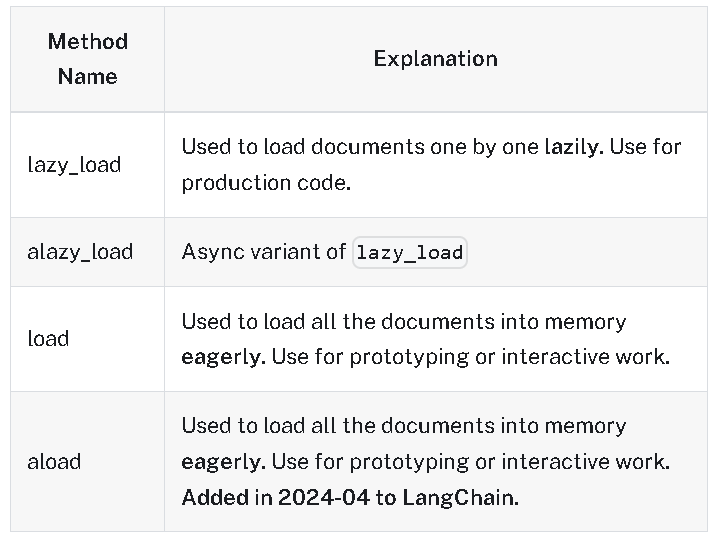

- load 메소드는 list(self.lazy_load())를 호출합니다.
- alazy_load에는lazy_load에 위임할 기본 구현이 있습니다. 비동기를 사용하는 경우 기본 구현을 재정의하고 기본 비동기 구현을 제공하는 것이 좋습니다.
- ※ 문서 로더를 구현할 때 lazy_load 또는 alazy_load 메소드에 매개변수를 제공하지 마십시오
- 모든 구성은 초기화 프로그램(init)을 통해 전달될 것으로 예상됩니다. 이는 일단 `문서 로더가 인스턴스화되면 문서를 로드하는 데 필요한 모든 정보가 있는지 확인하기 위해 LangChain이 선택한 설계`입니다.

In [7]:
from typing import AsyncIterator, Iterator

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document

class CustomDocumentLoader(BaseLoader):
    """An example document loader that reads a file line by line."""

    def __init__(self, file_path: str) -> None:
        """Initialize the loader with a file path.

        Args:
            file_path: The path to the file to load.
        """
        self.file_path = file_path
        
    def lazy_load(self) -> Iterator[Document]:
        """A lazy loader that reads a file line by line.

        When you're implementing lazy load methods, you should use a generator
        to yield documents one by one.
        """
        with open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1
                
    # alazy_load is OPTIONAL.
    # If you leave out the implementation, a default implementation which delegates to lazy_load will be used!
    async def alazy_load(
        self,
    ) -> AsyncIterator[Document]:  # <-- Does not take any arguments
        """An async lazy loader that reads a file line by line."""
        # Requires aiofiles
        # Install with `pip install aiofiles`
        # https://github.com/Tinche/aiofiles
        import aiofiles

        async with aiofiles.open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            async for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1



In [10]:
with open("./meow.txt", "w", encoding="utf-8") as f:
    quality_content = "meow meow🐱 \n meow meow🐱 \n meow😻😻"
    f.write(quality_content)

loader = CustomDocumentLoader("./meow.txt")

## Test out the lazy load interface
for doc in loader.lazy_load():
    print()
    print(type(doc))
    print(doc)
    
loader.lazy_load() # 제너레이터이다


<class 'langchain_core.documents.base.Document'>
page_content='meow meow🐱 \n' metadata={'line_number': 0, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 \n' metadata={'line_number': 1, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow😻😻' metadata={'line_number': 2, 'source': './meow.txt'}


<generator object CustomDocumentLoader.lazy_load at 0x000001B71B0420B0>

In [ ]:
## Test out the async implementation
async for doc in loader.alazy_load():
    print()
    print(type(doc))
    print(doc)

In [11]:
loader.load()

[Document(page_content='meow meow🐱 \n', metadata={'line_number': 0, 'source': './meow.txt'}),
 Document(page_content=' meow meow🐱 \n', metadata={'line_number': 1, 'source': './meow.txt'}),
 Document(page_content=' meow😻😻', metadata={'line_number': 2, 'source': './meow.txt'})]

### Working with Files
- 많은 문서 로더는 '파싱 파일'을 사용합니다. 로더간의 차이는 파싱 방식의 차이에 있습니다.
- 따라서, 파싱 로직을 분석해 보는 것은 문서 종류와 상관 없이 파서를 재사용하는데 도움이 됩니다.

#### BaseBlobParser
- BaseBlobParser는 blob을 받아들어서, Document 객체 리스트를 출력으로 냅니다.
- blob은 메모리나 파일상에 존재하는 데이터의 표현입니다.
- LangChain Python에는 Blob WebAPI 사양에서 영감을 받은 Blob 기본 요소가 있습니다.

In [13]:
from langchain_core.document_loaders import BaseBlobParser, Blob


class MyParser(BaseBlobParser):
    """A simple parser that creates a document from each line."""

    def lazy_parse(self, blob: Blob) -> Iterator[Document]:
        """Parse a blob into a document line by line."""
        line_number = 0
        with blob.as_bytes_io() as f:
            for line in f:
                line_number += 1
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": blob.source}
                )
    

In [14]:
blob = Blob.from_path("./meow.txt")
parser = MyParser()

list(parser.lazy_parse(blob))
# BaseLoader.load()와 결과가 같은데 왜 사용되야 하는지??

[Document(page_content='meow meow🐱 \r\n', metadata={'line_number': 1, 'source': './meow.txt'}),
 Document(page_content=' meow meow🐱 \r\n', metadata={'line_number': 2, 'source': './meow.txt'}),
 Document(page_content=' meow😻😻', metadata={'line_number': 3, 'source': './meow.txt'})]

- 또한 Blob API를 사용하면 파일에서 콘텐츠를 읽지 않고도 메모리에서 직접 콘텐츠를 로드할 수 있습니다!

In [15]:
blob = Blob(data=b"some data from memory\nmeow") # 메모리에서 직접 로드
list(parser.lazy_parse(blob))

[Document(page_content='some data from memory\n', metadata={'line_number': 1, 'source': None}),
 Document(page_content='meow', metadata={'line_number': 2, 'source': None})]

In [18]:
blob = Blob.from_path("./meow.txt", metadata={"foo": "bar"})
print(blob.encoding); print()
print(blob.as_bytes()); print()
print(blob.as_string()); print()
print(blob.as_bytes_io()); print()
print(blob.metadata); print()
print(blob.source); print()

utf-8

b'meow meow\xf0\x9f\x90\xb1 \r\n meow meow\xf0\x9f\x90\xb1 \r\n meow\xf0\x9f\x98\xbb\xf0\x9f\x98\xbb'

meow meow🐱 
 meow meow🐱 
 meow😻😻


{'foo': 'bar'}

./meow.txt



#### Blob Loaders
- BaseBlobParser는 바이너리 데이터를 문서로 구문 분석하는데 필요한 논리를 캡슐화 하는 반면, 
- blob_loaders는 지정된 저장소 위치에서 Blob을 로드하는 데 필요한 논리를 캡슐화합니다.
- 현재 LangChain은 FileSystemBlobLoader만 지원합니다.
- FileSystemBlobLoader를 사용하여 Blob을 로드한 다음 파서를 사용하여 구문 분석할 수 있습니다.

In [21]:
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader

blob_loader = FileSystemBlobLoader(path=".", glob="*.txt", show_progress=True)

In [22]:
parser = MyParser()
for blob in blob_loader.yield_blobs():
    for doc in parser.lazy_parse(blob):
        print(doc)
        break

  0%|          | 0/1 [00:00<?, ?it/s]

page_content='meow meow🐱 \r\n' metadata={'line_number': 1, 'source': 'meow.txt'}


#### Generic Loader
- Langchain에는 BaseBlobParser로 BlobLoader를 구성하는 GenericLoader 추상화가 있습니다.
- GenericLoader는 기존 BlobLoader 구현을 쉽게 사용할 수 있도록 표준화된 클래스 메서드를 제공하기 위한 것입니다. 현재는 FileSystemBlobLoader만 지원됩니다.

In [23]:
from langchain_community.document_loaders.generic import GenericLoader

loader = GenericLoader.from_filesystem(
    path=".", glob="*.txt", show_progress=True, parser=MyParser()
)

for idx, doc in enumerate(loader.lazy_load()):
    if idx < 5:
        print(doc)

print("... output truncated for demo purposes")

  0%|          | 0/1 [00:00<?, ?it/s]

page_content='meow meow🐱 \r\n' metadata={'line_number': 1, 'source': 'meow.txt'}
page_content=' meow meow🐱 \r\n' metadata={'line_number': 2, 'source': 'meow.txt'}
page_content=' meow😻😻' metadata={'line_number': 3, 'source': 'meow.txt'}
... output truncated for demo purposes
